In [4]:
import pandas as pd
import numpy as np
import os
import zipfile
import re
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import OneHotEncoder

In [2]:
archive = zipfile.ZipFile('dataset.zip', 'r')
[z for z in [re.findall('filename=\'(.+?)\'',y)[0] for y in [str(x) for x in archive.filelist]] if z.find('MAC')<0]

['clients.csv', 'editors.csv', 'tickets.csv', 'tasks.csv']

In [3]:
clients = pd.read_csv(BytesIO(archive.read('clients.csv')))
editors = pd.read_csv(BytesIO(archive.read('editors.csv')))
tasks = pd.read_csv(BytesIO(archive.read('tasks.csv')))
tickets = pd.read_csv(BytesIO(archive.read('tickets.csv')))

In [8]:
# merge tables
tickets_clients = pd.merge(left=tickets, right=clients, how='left', left_on='client_id.1', right_on='id')
tasks_tickets_clients = pd.merge(left=tasks, right=tickets_clients, how='left', left_on='ticket_id', right_on='id_x')
domains = 'travel,fintech,ecommerce,sports,gamming,health_care'.split(',')

# Summary
- Tickets are broken into tasks, that are assigned to editors.
- Tasks have a language pair, a certain number of words, and a specific domain.
- Editors' skills are broken down per domain. --> *language_pair is missing.*
- Task assignment problem:
    - task quality is dependent on the editors skill, so editors with better skill at the task's domain should be assigned to it.
    - assignment should be balanced so that all the editors can eat.
    
**Approach**
- assign language_pairs to editors, break the problem per language (language_pairs proportion is similar over the domains).
- optimize task assignment with constrains on quality (editor's domain skill) and assignment balance (avoid concentration).

## There is an imbalance at task domain

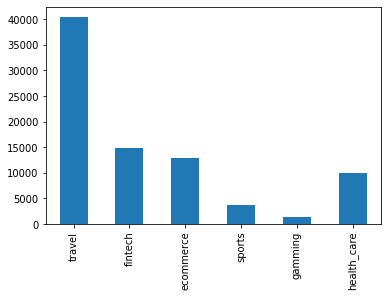

In [32]:
p = tasks_tickets_clients['domain'].value_counts()[domains].plot(kind='bar')

## Also at editors skills
Travel skills are the most lacking while most tasks are in the travel domain

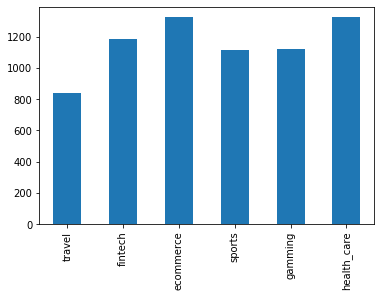

In [31]:
p = editors[domains].sum(axis=0).plot(kind='bar')

## language_pair proportion is similar over the domains

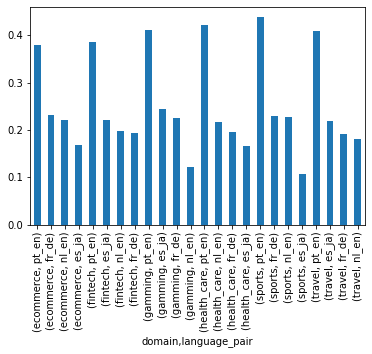

In [30]:
p = tasks_tickets_clients.groupby('domain')['language_pair'].value_counts(normalize=True).plot(kind='bar')

In [33]:
# editors do not have language pair -- assign randomly with the same distribution as in tasks
editors.drop(editors.columns[0], axis=1, inplace=True)
editors.reset_index(inplace=True)
editors_r = editors.sample(frac=1, random_state=42)
editors_r.reset_index(drop=True, inplace=True)
editors_r['language_pair'] = tasks_tickets_clients.language_pair.sample(n=editors.shape[0], random_state=42).values

In [34]:
# break the problem for 1 language pair = nl_en
# nl_en
nl_en_tasks = tasks_tickets_clients.loc[tasks_tickets_clients['language_pair'] == 'nl_en']
# create a zero-one matrix of domain per tasks
enc = OneHotEncoder()
nl_en_jde = enc.fit_transform(nl_en_tasks['domain'][:, None]).toarray()
# fix col order to ['travel', 'fintech', 'ecommerce', 'sports', 'gamming', 'health_care']
nl_en_jdedf = pd.DataFrame(nl_en_jde, columns=enc.categories_)
nl_en_job_domain = nl_en_jdedf[domains].values
# array of tasks' number of words 
nl_en_job_words = nl_en_tasks['number_words_x'].values
# editors
nl_en_editors = editors_r[editors_r['language_pair'] == 'nl_en']
# matrix of editors' domain skill
nl_en_editor_domain_skill = nl_en_editors[domains].values
# defining task quality per editor's skill. Weighted Domain Skill = average skill * domain skill
    # matrix of editor quality per domain
nl_en_editor_domain_quality = pd.DataFrame(nl_en_editor_domain_skill).apply(lambda x: np.mean(x / 5) * (x / 5),
                                                                            axis=1).values

# Optimization with a Genetic Algorithm (GA)
To optimize task assignment, jobs will be assigned to editors in a zero-one matrix, with editors on rows and jobs on columns

In [42]:
# for instance
pd.DataFrame([[1,0,0],[0,1,0],[0,0,1]],columns='task_1,task_2,task_3'.split(','),\
             index='editor_1,editor_2,editor_3'.split(','))

,task_1,task_2,task_3
editor_1,1,0,0
editor_2,0,1,0
editor_3,0,0,1


The initial order will be randomly generated, preventing the formation of zero-only rows (where an editor would have no tasks).
The sequence of the GA will be the following:
- a random population of chromosomes is generated;
- the population is ranked by a fitness function;
- the next generation is selected:
    - a group of the population is selected to pass to the next generation (elite);
    - another group is selected for breeding, by chance with proportion to fitness;
    - inverted exchange crossover is performed on chromosomes to generate the offspring;
    - the whole population is submitted to mutation at a mutation rate - mutation is swapping of adjacent columns.
- this is repeated for N generations.

The fitness function will be based on the total quality of the tasks (sum) multiplied by a balance factor. This balance factor will take into consideration:
    - the distance between the maximum and minimum number of tasks per agent;
    - the skewness and the kurtosis of the task distribution. 
    - the factors are created so to minimize skewness in both directions and 
    minimize overall kurtosis, which will force a uniform distribution.
    - a penalty factor can be used to increase or decrease the balancing factor's effect.

In [43]:
from genetic import gen_pop_mp, genetic_algorithm_mp

In [5]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import pandas; print("Pandas", pandas.__version__)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
import matplotlib; print('matplotlib', matplotlib.__version__)

Windows-10-10.0.18362-SP0
Python 3.6.7 |Anaconda, Inc.| (default, Oct 28 2018, 19:44:12) [MSC v.1915 64 bit (AMD64)]
Pandas 0.25.2
NumPy 1.16.5
SciPy 1.3.1
Scikit-Learn 0.21.3
matplotlib 3.1.1
